import, set root

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

import glob, os, sys
import numpy as np
from scipy.stats import zscore, spearmanr, mannwhitneyu, pearsonr
import time
import imp
import steinmetz_loader
from scipy.sparse import csr_matrix

imp.reload(steinmetz_loader)

In [133]:
import pandas as pd
import glob
import seaborn as sns
from matplotlib import interactive
interactive(True)
from sklearn.decomposition import PCA 

change the path based on where your data is 

In [3]:
dataroot = "E:\\NMA\\Steinmetz-data\\Spikes"
fdir = glob.glob(os.path.join(dataroot, "Lederberg_*", ""))
fdir

['E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-05\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-06\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-07\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-08\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-09\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-10\\',
 'E:\\NMA\\Steinmetz-data\\Spikes\\Lederberg_2017-12-11\\']

use steinmetz_loader to create dat dictionaries

In [7]:
dt = 1/100
dT = 2.5
T0 = .5

dat = []

for idir in range(len(fdir)):
    # good cells and brain regions
    good_cells, brain_region, br = steinmetz_loader.get_good_cells(fdir[idir])
    
    # event types
    response, vis_right, vis_left, feedback_type = steinmetz_loader.get_event_types(fdir[idir])
    
    # event timing
    response_times, visual_times, rsp, gocue, feedback_time = steinmetz_loader.get_event_times(fdir[idir])    

    # get passive trials
    vis_times_p, vis_right_p, vis_left_p = steinmetz_loader.get_passive(fdir[idir])
    visual_times = np.vstack((visual_times, vis_times_p))
    vis_right = np.hstack((vis_right, vis_right_p))
    vis_left  = np.hstack((vis_left, vis_left_p))
    
    # wheel traces
    stimes, sclust    = steinmetz_loader.get_spikes(fdir[idir])
    
    # only care about spikes during trials
    wheel, wheel_times = steinmetz_loader.get_wheel(fdir[idir])
    
    # load the pupil
    pup, xy, pup_times = steinmetz_loader.get_pup(fdir[idir])

    # load the LFP
    # L, ba_lfp = steinmetz_loader.get_LFP(fdir[idir], br, visual_times-T0, dT, dt, T0)
    
    # trials loader
    S  = steinmetz_loader.psth(stimes, sclust,   visual_times-T0, dT, dt)
    
    # wheel trials
    W = steinmetz_loader.wpsth(wheel, wheel_times,   visual_times-T0, dT, dt)
    
    # pupil loader
    P = steinmetz_loader.ppsth(pup, pup_times,   visual_times-T0, dT, dt)
    
    # add spike waveform information
    twav, w, u = steinmetz_loader.get_waves(fdir[idir])
    
    
    good_cells = good_cells * (np.mean(S, axis=(1,2))>0)
    S  = S[good_cells].astype('int8') 
   
    dat.append({})
    dat[idir]['response'] = response
    ntrials = len(dat[idir]['response'])
    
    dat[idir]['brain_area'] = brain_region[good_cells]
    dat[idir]['spks'] = S[:, :ntrials, :]
    dat[idir]['wheel'] = W[np.newaxis, :ntrials, :]
    dat[idir]['pupil'] = P[:, :ntrials, :]
    dat[idir]['contrast_right'] = vis_right[:ntrials]
    dat[idir]['contrast_left'] = vis_left[:ntrials]
    dat[idir]['response_time'] = rsp
    dat[idir]['feedback_time'] = feedback_time
    dat[idir]['feedback_type'] = feedback_type  
    dat[idir]['gocue'] = gocue
    dat[idir]['mouse_name'] = fdir[idir].split('\\')[4].split('_')[0]
    dat[idir]['date_exp'] = fdir[idir].split('\\')[4].split('_')[1]
    dat[idir]['trough_to_peak'] = twav[good_cells].flatten()
    dat[idir]['waveform_w'] = w[good_cells].astype('float32')
    dat[idir]['waveform_u'] = u[good_cells].astype('float32')
    dat[idir]['bin_size'] = dt
    dat[idir]['stim_onset'] = T0
    
    dat[idir]['spks_passive'] = S[:, ntrials:, :]
    dat[idir]['wheel_passive'] = W[np.newaxis, ntrials:, :]
    dat[idir]['pupil_passive'] = P[:, ntrials:, :]
    #dat[idir]['lfp_passive'] = L[:, ntrials:, :]
    dat[idir]['contrast_right_passive'] = vis_right[ntrials:]
    dat[idir]['contrast_left_passive'] = vis_left[ntrials:]
        
    # add LFP
    #L, ba_lfp = steinmetz_loader.get_LFP(fdir[idir], br, visual_times-T0, dT, dt, T0)
    #dat[idir]['lfp'] = L[:, :ntrials, :]
    #dat[idir]['lfp_passive'] = L[:, ntrials:, :]
    #dat[idir]['brain_area_lfp'] = ba_lfp
  
    #S  = np.reshape(S[good_cells], (np.sum(good_cells), -1))
    #sall.append(csr_matrix(S))

In [9]:
dat[6].keys()

dict_keys(['response', 'brain_area', 'spks', 'wheel', 'pupil', 'contrast_right', 'contrast_left', 'response_time', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'bin_size', 'stim_onset', 'spks_passive', 'wheel_passive', 'pupil_passive', 'contrast_right_passive', 'contrast_left_passive'])

**add cell measures and add spike_counts from dat files**

In [101]:
csvroot = "E:\\NMA\\Steinmetz-data\\"
csvfiles = glob.glob(csvroot + "*.csv")

cellmeasure_dfs = [pd.read_csv(file) for file in csvfiles]

for i in range(len(dat)):
    spike_counts = dat[i]['spks'].sum(axis=(1,2))
    cellmeasure_dfs[i] = pd.concat([cellmeasure_dfs[i], pd.DataFrame({'Spike_count': spike_counts})], axis=1)

In [103]:
cellmeasure_dfs[0]

,ID,Cell_type,Brain_region,Trough_Peak_latency,ACG_tau_decay,ACG_tau_rise,Peak_asymmetry,Burst_index,RF_violation,Spike_count
0,0,Wide Interneuron,VISp,0.716667,8.856992,8.878201,1.076966,0.070679,0.404367,622
1,1,Pyramidal Cell,VISp,0.633333,11.118077,2.065711,1.100548,4.101313,3.980725,202
2,2,Wide Interneuron,VISp,0.741667,17.278337,7.948613,1.023433,0.000000,0.093188,4563
3,3,Pyramidal Cell,DG,0.591667,6.164531,0.527944,1.026793,166.229167,3.225806,162
4,4,Wide Interneuron,VISp,0.608333,4.566807,3.906423,-0.138177,1.783967,2.749771,1153
...,...,...,...,...,...,...,...,...,...,...
693,693,Wide Interneuron,MD,0.550000,12.903135,7.347009,0.956221,5.315789,0.000000,426
694,694,Wide Interneuron,VISam,0.650000,10.089507,4.809336,0.917609,0.000000,0.000000,14
695,695,Wide Interneuron,VISam,0.625000,17.593011,4.026267,1.069532,22.444444,0.000000,55
696,696,Pyramidal Cell,CA1,0.641667,2.762503,2.693825,0.013612,83.176471,7.092199,55


In [132]:
# find what brain regions have been recorded from in each session
for j in range(len(dat)): 
    b_areas, area_counts = np.unique(dat[j]['brain_area'],return_counts=True)
    print(b_areas)

['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']
['ACA' 'CA1' 'DG' 'LGd' 'MB' 'MOs' 'MRN' 'MS' 'PL' 'RN' 'SCm' 'SCs'
 'VISam' 'ZI' 'root']
['CA1' 'MOs' 'MRN' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'VISp' 'root']
['BLA' 'CA3' 'GPe' 'LGd' 'MB' 'VPM' 'ZI' 'root']
['CA3' 'LGd' 'MB' 'SSp' 'SSs' 'TH']
['LD' 'MEA' 'RT' 'VPL' 'VPM' 'root']
['ACB' 'CA3' 'CP' 'LGd' 'OT' 'SI' 'SNr' 'TH' 'ZI' 'root']


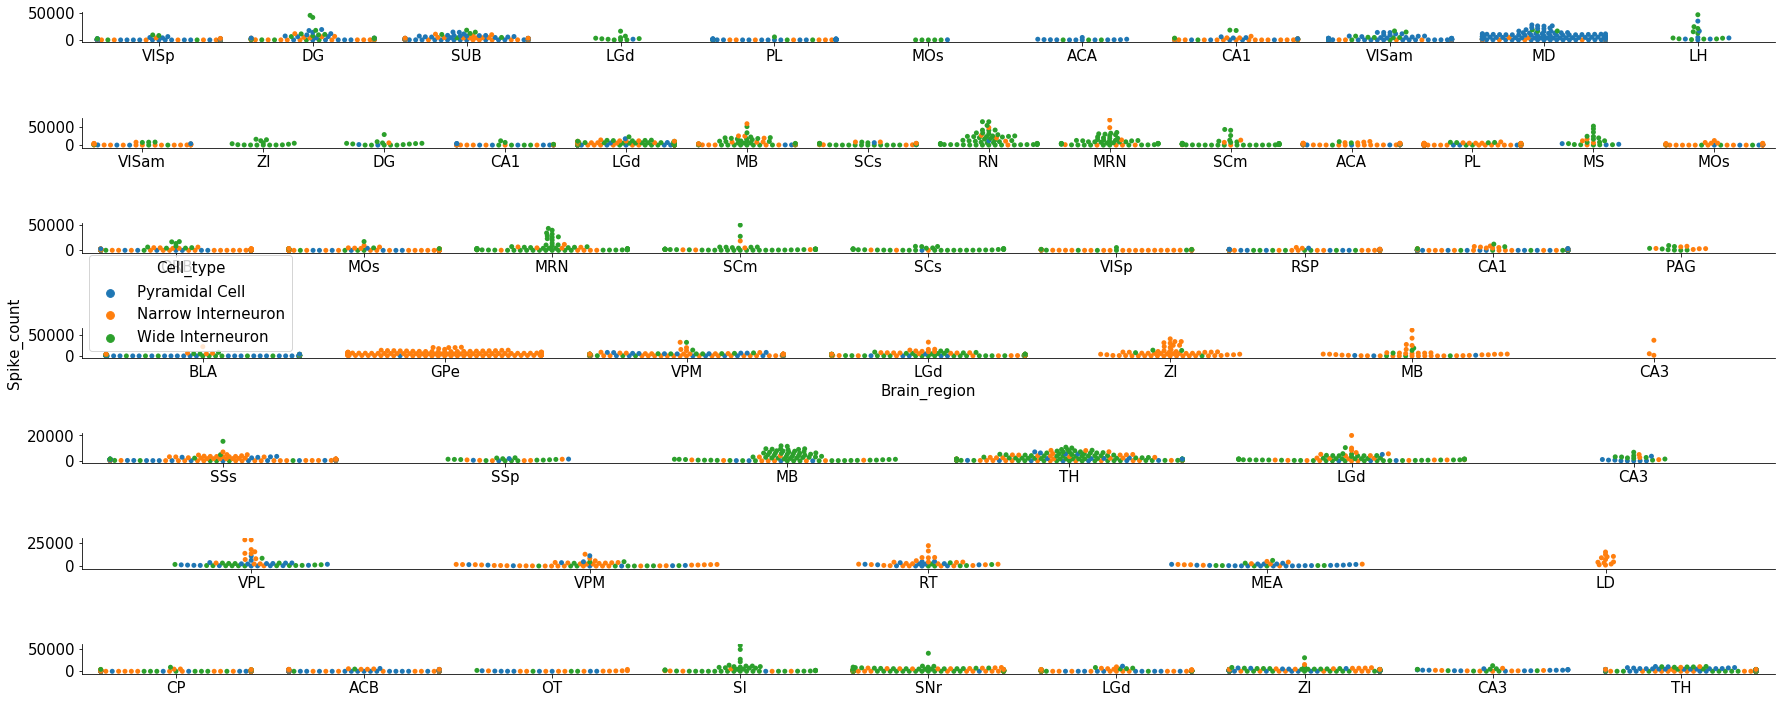

In [129]:
# plot all neurons' spike counts, colored by their cell type, just to have a sense of how active the region was and what regions were recorded from, and what cell types where present
fig, ax = plt.subplots(len(dat), 1, figsize=(25,10))
for j in range(len(dat)): 
    sns.swarmplot(y='Spike_count', x='Brain_region',hue = 'Cell_type', data=cellmeasure_dfs[j], ax=ax[j])
    if j!=3: 
        ax[j].legend_ = None
        ax[j].set(xlabel=None, ylabel=None)



# manifolds

In [191]:
# function for computing PCs
def get_PCs(spiketrains):
    NN = spiketrains.shape[0] # number of neurons
    NT = spiketrains.shape[2] # number of bins
    droll = np.reshape(spiketrains[:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec, concatenate all trials
    droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
    model = PCA(n_components = 5).fit(droll.T) # fit the model to the first 80 bins after stim
    W = model.components_
    PCs = W @ np.reshape(spiketrains, (NN,-1)) # apply to all trial
    PCs = np.reshape(PCs, (5, -1, NT))
    return PCs

In [192]:
# get the PCs and get the average PCs across trials
PCs=[]
lowD_PC=[]
for j in range(len(dat)):
    PCs.append({})
    lowD_PC.append({})
    PCs[j] = get_PCs(dat[j]['spks']) # get the mean PCs across all trials in that session
    lowD_PC[j] = PCs[j][:3,:,:].mean(axis=1)


In [151]:
from mpl_toolkits.mplot3d import Axes3D

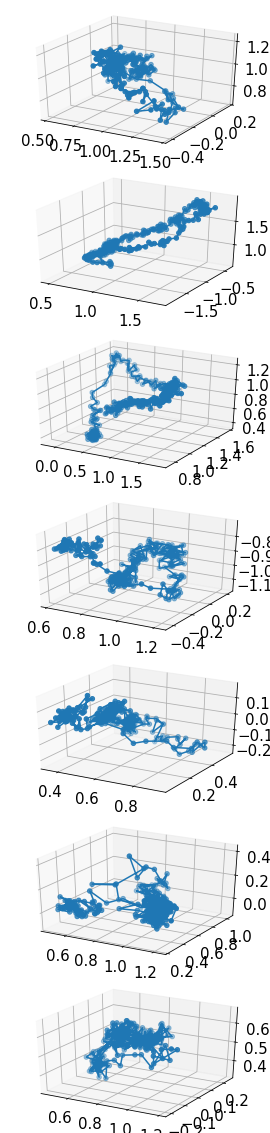

In [196]:
# plot manifolds 
fig = plt.figure(figsize = plt.figaspect(20))
for j in range(len(lowD_PC)): 
    ax = fig.add_subplot(len(dat), 1, j+1, projection='3d')
    ax.plot3D(lowD_PC[j][0,:], lowD_PC[j][1,:], lowD_PC[j][2,:])
    ax.scatter3D(lowD_PC[j][0,:], lowD_PC[j][1,:], lowD_PC[j][2,:])

plot manifolds from correct trials


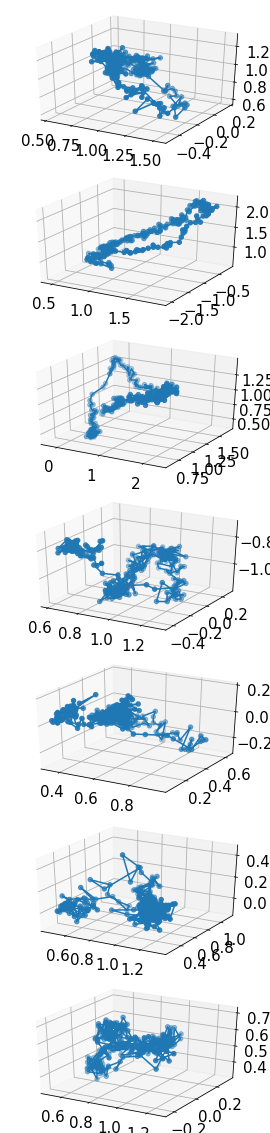

In [202]:
fig = plt.figure(figsize = plt.figaspect(20))
for j in range(len(lowD_PC)): 
    
    response = dat[j]['response'] # right - nogo - left (-1, 0, 1)
    vis_right = dat[j]['contrast_right'] # 0 - low - high
    vis_left = dat[j]['contrast_left'] # 0 - low - high
    
    is_correct = np.sign(response)==np.sign(vis_left-vis_right)
    
    lowD_PC = PCs[j][:3,is_correct,:].mean(axis=1)

    ax = fig.add_subplot(len(dat), 1, j+1, projection='3d')
    ax.plot3D(lowD_PC[0,:], lowD_PC[1,:], lowD_PC[2,:])
    ax.scatter3D(lowD_PC[0,:], lowD_PC[1,:], lowD_PC[2,:])